# Twiss

This is an example of plotting lines and twiss results.
First, create a simple line and a tracker:

In [1]:
import xtrack as xt
import xpart as xp
import xplt
import numpy as np

In [ ]:
## Generate a simple 6-fold symmetric FODO lattice
n = 6
elements = []
for i in range(n):
    elements.extend(
        [
            xt.Drift(length=0.7),
            xt.Multipole(length=0.3, knl=[0, +0.63], ksl=[0, 0]),
            xt.Drift(length=0.7),
            xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
            xt.Drift(length=0.4),
            xt.Multipole(length=0.2, knl=[0, 0, 0.5 * np.sin(2 * np.pi * (i / n))]),
            xt.Drift(length=0.3),
            xt.Multipole(length=0.3, knl=[0, -0.48], ksl=[0, 0]),  # -0.4
            xt.Drift(length=0.7),
            xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
            xt.Drift(length=2.2),
        ][:: -1 if i % 2 else 1]
    )
elements.append(xt.LimitRect(min_x=-0.01, max_x=0.01, min_y=-np.inf, max_y=np.inf))
line = xt.Line(elements=elements)

line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
tracker = xt.Tracker(line=line)

Then determine it's twiss parameters. We use the `at_s` parameter to get the result as function of s rather than at each element only.

In [3]:
tw = tracker.twiss(
    method="4d",
    at_s=np.linspace(0, line.get_length(), 500),
)
print(f"qx: {tw.qx:g}")
print(f"qy: {tw.qy:g}")

qx: 2.33247
qy: 1.12177


## Default twiss plot

Create a default {class}`TwissPlot <xplt.twiss.TwissPlot>`:

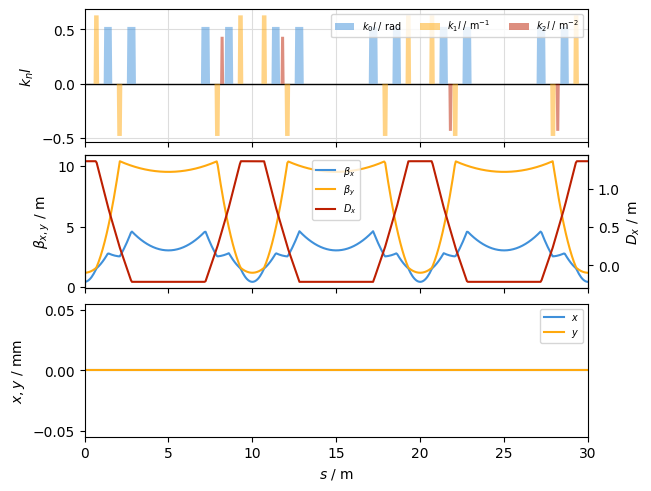

In [4]:
plot = xplt.TwissPlot(tw, line=line)

## Customisation

Use the parameter `kind` to specify what is plotted. See {class}`TwissPlot <xplt.twiss.TwissPlot>` for details.

In [5]:
print(", ".join(tw.keys()))

name, s, x, px, y, py, zeta, delta, ptau, betx, bety, alfx, alfy, gamx, gamy, dx, dpx, dy, dzeta, dpy, mux, muy, muzeta, W_matrix, betx1, bety1, betx2, bety2, _ebe_fields, particle_on_co, circumference, qx, qy, qs, dqx, dqy, slip_factor, momentum_compaction_factor, betz0, T_rev, c_minus, R_matrix, values_at


```{tip}
Use prefix notation as shorthand to plot both x- and y-properties, e.g. `bet` for `betx+bety`
```

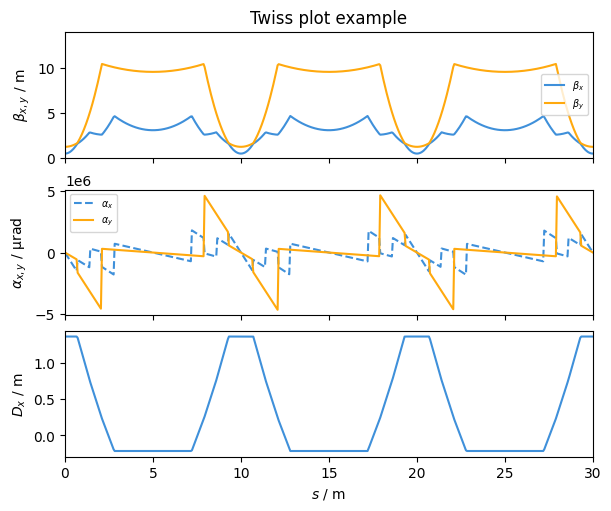

In [6]:
plot = xplt.TwissPlot(tw, figsize=(6, 5), kind="bet,alfx+alfy,dx", display_units=dict(alf="urad"))

# adjust some axes
plot.ax[0].set(title="Twiss plot example", ylim=(0, 14))
plot.ax[0].legend(loc="right")

# adjust line layout
plot.artists[1][0][0].set_ls("--")
plot.ax[1].legend();

-----------------
```{seealso}
- {class}`xplt.twiss`
```